#### **Figure 1. Publications on Tourette syndrome.** The number of new publications on Tourette syndrome or other tic disorders each year was estimated from PubMed. The colored line is a LOWESS (locally weighted scatterplot smoothing) curve from the primary data. 

[PubMed](http://www.ncbi.nlm.nih.gov/pubmed) was searched on 14 Jun 2023 using the search string 
“`("Tic Disorders"[MeSH] OR Tourette*[All Fields] OR "tourettism"[All Fields]) NOT ((Tourette[AU] OR Tourette[COIS]) NOT ("Tic Disorders"[MeSH] OR tourette*[tw] OR tourette*[tiab] OR tourette*[ot] OR "tourettism"[All Fields])) AND 2023[PDAT] NOT 1950:2022[PDAT]`” for various values of `year`, where `prev` means `year - 1`. This strategy addresses PubMed’s listing both electronic and subsequent paper publication dates for about 250 TS publications since 2005. PubMedCentral was searched with a similar strategy, substituting `"tic disorders"[mesh] OR tourette*[tw] OR tourettism[tw]` for the part of the search string before the year. The graph was generated by [matplotlib](http://matplotlib.org) in python (see supplementary material).

In [1]:
with open('NCBI_API_key_2023old.txt', 'r') as keyfile:
    api_key=keyfile.read()

In [8]:
from time import sleep
import xml.etree.ElementTree as ET
import sys  # all I need is sys.stdout
import requests

# https://www.educba.com/python-curl/
# https://docs.python.org/3/library/xml.etree.elementtree.html
# https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&api_key=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&term=(%22tic+disorders%22[mesh]+or+tourette+not+tourette[au])+and+2021[pdat]+not+1850[pdat]:2020[pdat]
# See also egquery.fcgi
baseurl = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
retmax = 10 # PMIDs listed; default is 20
mode = 'retmode=xml' # esearch.fcgi appends this by default
# headers={'x-api-key':'09ba90f6-dcd0-42c0-8c13-5baa6f2377d0'}
# resp = requests.get(url,headers=headers)

databases = ["pubmed", "pmc"]
ancient = 1800
startyear = 1940
# endyear = 2025
endyear = 2022
bases = ['','']  # pubmed, PMC respectively
bases[0] = '%22tic+disorders%22[mesh]+OR+tourette%2A[All+Fields]+OR+%22tourettism%22[All+Fields]' +\
    '+NOT+' +\
    '((tourette%2A[au]+OR+tourette%2A[cois])' +\
    '+NOT+' + \
    '(%22tic+disorders%22[mesh]+OR+tourette%2A[tw]+OR+tourette%2A[tiab]' +\
    '+OR+tourette%2A[ot]+OR+%22tourettism%22[All+Fields]))' + '+AND+'
bases[1] = '%22tic+disorders%22[mesh]+OR+tourette%2A[ti]+OR+' +\
    'tourette%2A[ab]+OR+tourette%2A[kwd]+OR+tourettism[tw]' + '+AND+'

SHOW_PROGRESS = True

def print_progress(year):
    if year % 10 == 0:
        print(year, sep='', end='')
    elif year % 5 == 0:
        print('5', sep='', end='')
    else:
        print('.', sep='', end='')    

def print_line(year, database_list, outfile=sys.stdout):
    errormsg = ''
    line = str(year)
    if year == 'pre-'+str(startyear):
#        term = baseterm + str(ancient) + ':' + str(startyear-1) + '[pdat]'
        dateterm = str(ancient) + ':' + str(startyear-1) + '[pdat]'
    else:
#        term = baseterm + str(year)+'[pdat]+not+'+str(ancient)+'[pdat]:'+str(year-1)+'[pdat]'
        dateterm = str(year)+'[pdat]+not+'+str(ancient)+'[pdat]:'+str(year-1)+'[pdat]'
    for db in database_list:
        term = bases[database_list.index(db)] + dateterm
        url = baseurl+'esearch.fcgi'+'?db='+db+'&api_key='+api_key+'&term='+term 
        resp = requests.get(url)
        sleep(0.100) # seconds, because I'm not supposed to query more than 10 times a second 
        check = resp.status_code
        if check != 200:
            errormsg = 'CAREFUL, request status code = ' + str(check)
        root = ET.fromstring(resp.content)
        line = line + ',' + root.find('Count').text
    if (SHOW_PROGRESS) and (year != "pre-"+str(startyear)):
        print_progress(year)
    line = line + ',' + errormsg
    print(line, file=outfile)

RELOAD_FROM_NCBI = True
REPRINT_TABLE_TO_SCREEN = False

if RELOAD_FROM_NCBI:
    with open('TS_publications_20230615.csv', 'w') as f:
        print("year,pubmed,pmc,errors", file=f)
        print_line('pre-'+str(startyear), databases, outfile=f)
        for year in range(startyear,endyear+1):
            print_line(year, databases, outfile=f)

if REPRINT_TABLE_TO_SCREEN:
    if RELOAD_FROM_NCBI:
        print('The table below is from fresh data.')
    else:
        print('The table below is from STALE data.')
    print("\n")
    print("year,pubmed,pmc,errors")
    print_line('pre-'+str(startyear), databases)
    for year in range(startyear,endyear+1):
        print_line(year, databases)

1940.........1950.........1960.........1970.........1980.........1990.........2000.........2010.........2020..

In [9]:
import numpy as np
import csv
with open('TS_publications_20230615.csv', 'rb') as datafile:
    data = np.recfromcsv(datafile, names=True, dtype=int)
years  = data['year'][1:]
pubmed = data['pubmed'][1:]
pmc    = data['pmc'][1:]

In [10]:
try:
    import statsmodels.api
except ModuleNotFoundError:
    !pip install statsmodels
import statsmodels.api as sm
b = sm.nonparametric.lowess(pubmed,years,frac=1./3)
c = sm.nonparametric.lowess(pmc,   years,frac=1./6)

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Named colors are shown here: https://matplotlib.org/3.3.1/gallery/color/named_colors.html
# Other colors (e.g. xkcd survey colors) are here: https://matplotlib.org/3.3.1/tutorials/colors/colors.html

f1000research_color=tuple([value/255.0 for value in (203,97,45)])
f1000research_h1   =tuple([value/255.0 for value in (55,67,76)])
f1000research_h2   =tuple([value/255.0 for value in (33,97,128)])

"""
Colors for Faculty Reviews:
RGB (0-255) = 
"""
fac_rev_color = tuple([value/100.0 for value in (81.2, 21.6, 22.4)]) # logo and references
fac_rev_c2    = tuple([value/100.0 for value in (23.5, 32.2, 37.3)]) # journal name text
fac_rev_c3    = tuple([value/100.0 for value in (21.6, 30.6, 34.9)]) # section headings
fac_rev_c4    = tuple([value/100.0 for value in ( 0.0, 41.6, 54.1)]) # subsection headings
fac_rev_c5    = tuple([value/100.0 for value in (74.9, 78.4, 83.5)]) # table header row
fac_rev_c6    = tuple([value/100.0 for value in (90.6, 91.4, 93.7)]) # table shading
fac_rev_c7    = tuple([value/100.0 for value in (83.9, 86.3, 89.0)]) # table lines
fac_rev_c8    = tuple([value/255.0 for value in (229.5, 22.9, 25.7)]) 
    # logo and references color, but brighter (HSV: H still = 359.2, but S = V = 90)

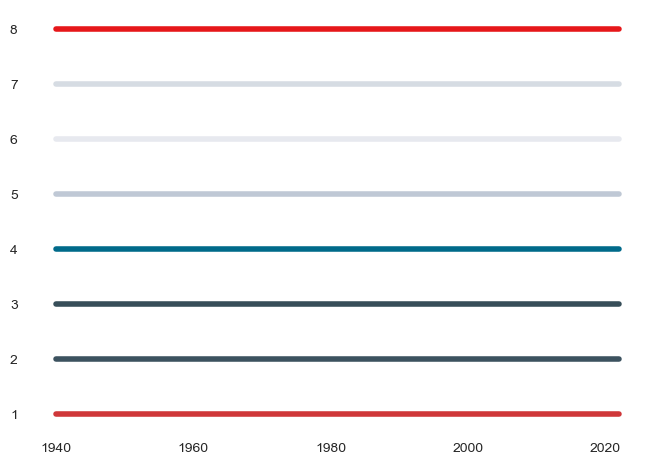

In [32]:
plt.clf()
plt.style.use('seaborn') 
ax = plt.gca()
ax.set_facecolor('white') # OR e.g. 'lavenderblush' 
plt.plot([1940,2022],[1,1],color=fac_rev_color,linewidth=4)
colors = [fac_rev_c2,fac_rev_c3,fac_rev_c4,fac_rev_c5,fac_rev_c6,fac_rev_c7,fac_rev_c8]
for num in range(7):
    plt.plot([1940,2022],[2+num,2+num],color=colors[num],linewidth=4)


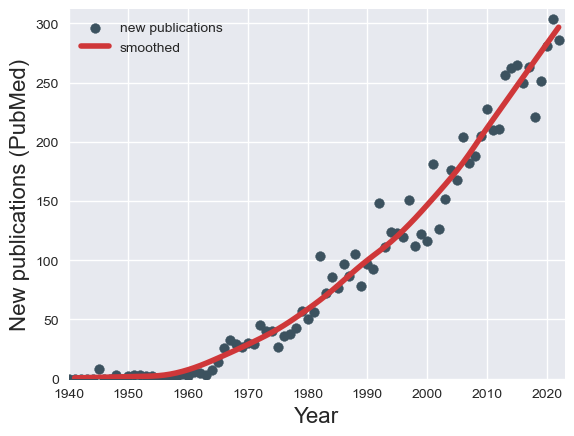

In [12]:
plt.clf()
plt.style.use('seaborn') 
ax = plt.gca()
ax.set_facecolor(fac_rev_c6) # OR e.g. 'lavenderblush' 
plt.scatter(years,pubmed,color=fac_rev_c2) # OR color='black'
plt.plot(b[1:,0],b[1:,1],color=fac_rev_color,linewidth=4) # OR color=fac_rev_c8, for a brighter LOWESS curve
plt.axis((years[0],1+years[-1],0,8+pubmed.max()))
plt.xlabel('Year',fontsize=16)
plt.ylabel('New publications (PubMed)',fontsize=16)
plt.legend(['new publications','smoothed'], loc='upper left')
# plt.savefig('TS_publications_2022.png', dpi=600, transparent=True) # only works with a clear background (duh)
plt.savefig('TS_publications_2022.png', dpi=600)
plt.show()

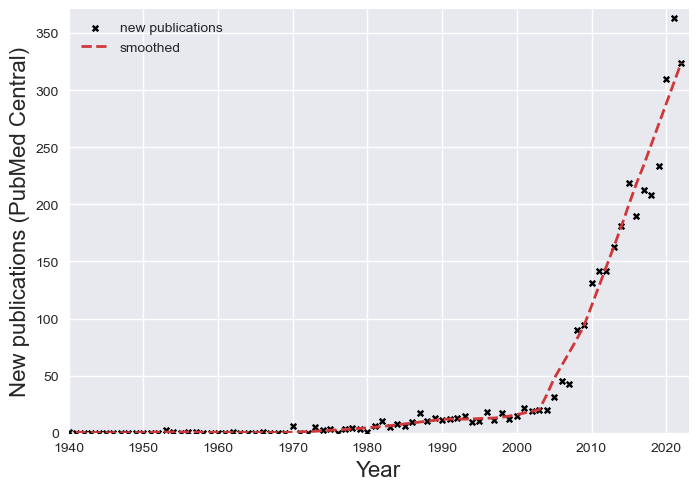

In [38]:
plt.clf()
plt.style.use('seaborn') 
ax = plt.gca()
ax.set_facecolor(fac_rev_c6) # OR e.g. 'lavenderblush' 
plt.scatter(years,pmc,marker="x",color='black',s=16) # OR color=fac_rev_c4; default size = 49.0
plt.plot(c[1:,0],c[1:,1],color=fac_rev_color,linewidth=2,linestyle='dashed') # OR color=fac_rev_c8, for a brighter LOWESS curve
plt.axis((years[0],1+years[-1],0,8+pmc.max()))
plt.xlabel('Year',fontsize=16)
plt.ylabel('New publications (PubMed Central)',fontsize=16)
plt.legend(['new publications','smoothed'], loc='upper left')
# plt.savefig('TS_publications_PMC_2022.png', dpi=600, transparent=True) # only works with a clear background (duh)
plt.savefig('TS_publications_PMC_2022.png', dpi=600)
plt.show()

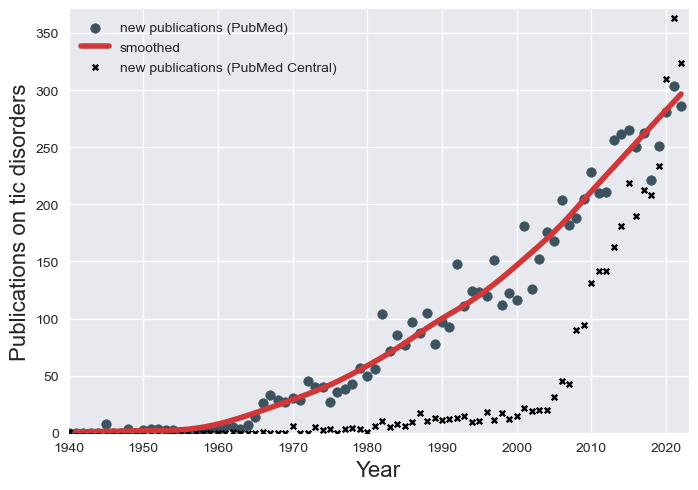

In [35]:
plt.clf()
plt.style.use('seaborn') 
ax = plt.gca()
ax.set_facecolor(fac_rev_c6) # OR e.g. 'lavenderblush' 
plt.scatter(years,pubmed,color=fac_rev_c2) # OR color='black'
plt.plot(b[1:,0],b[1:,1],color=fac_rev_color,linewidth=4) # OR color=fac_rev_c8, for a brighter LOWESS curve
plt.axis((years[0],1+years[-1],0,8+max(pubmed.max(),pmc.max())))
plt.scatter(years,pmc,marker="x",s=16,color='black') # OR color=fac_rev_c4 default size s=49
# plt.plot(c[1:,0],c[1:,1],color=fac_rev_color,linewidth=2,linestyle='dashed') # OR color=fac_rev_c8, for a brighter LOWESS curve
plt.xlabel('Year',fontsize=16)
plt.ylabel('Publications on tic disorders',fontsize=16)
plt.legend(['new publications (PubMed)','smoothed','new publications (PubMed Central)'], loc='upper left')
# plt.savefig('TS_publications_2022.png', dpi=600, transparent=True) # only works with a clear background (duh)
plt.savefig('TS_publications_both_2022.png', dpi=600)
plt.show()

In [22]:
plt.rcParams['lines.markersize'] ** 2

49.0